In [1]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import mplcursors
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

### What percentage of customers have churned in the last 30 days?

In [2]:
# Create the connection to BigQuery
project_id = 'instacart-441209'
DATABASE_URI = f'bigquery://{project_id}'
engine = create_engine(DATABASE_URI)

# Query to get the max days since prior order for each user
customer_activity_query = """
SELECT user_id, MAX(days_since_prior_order) AS max_days_since_prior
FROM `instacart-441209.instacart.orders`
GROUP BY user_id
"""

# Read data into DataFrame
customer_activity_df = pd.read_sql(customer_activity_query, engine)

# Define thresholds for active and inactive customers
inactive_customers = customer_activity_df[customer_activity_df['max_days_since_prior'] >= 30]
active_customers = customer_activity_df[customer_activity_df['max_days_since_prior'] < 30]

# Count of inactive and active customers
inactive_customers_30_days_count = inactive_customers['user_id'].nunique()
active_customers_30_days_count = active_customers['user_id'].nunique()

# Query to get total number of customers
total_customers_query = """
SELECT COUNT(DISTINCT user_id) AS total_customers
FROM `instacart-441209.instacart.orders`
"""

# Get the total number of unique customers
total_customers_df = pd.read_sql(total_customers_query, engine)
total_customers = total_customers_df['total_customers'][0]

# Calculate churn rate and active rate
churn_rate_30_days = (inactive_customers_30_days_count / total_customers) * 100
active_rate_30_days = (active_customers_30_days_count / total_customers) * 100

# Print results
print(f"Total number of unique customers: {total_customers}")
print(f"Number of active customers in the last 30 days: {active_customers_30_days_count}")
print(f"Number of inactive customers in the last 30 days: {inactive_customers_30_days_count}")
print(f"Churn rate for the last 30 days: {churn_rate_30_days:.2f}%")
print(f"Active rate for the last 30 days: {active_rate_30_days:.2f}%")

/var/folders/43/30gtvzf54299gghzdyc8_l900000gn/T/ipykernel_97989/1421610296.py:4: SADeprecationWarning: The dbapi() classmethod on dialect classes has been renamed to import_dbapi().  Implement an import_dbapi() classmethod directly on class <class 'pybigquery.sqlalchemy_bigquery.BigQueryDialect'> to remove this warning; the old .dbapi() classmethod may be maintained for backwards compatibility.
  engine = create_engine(DATABASE_URI)


Total number of unique customers: 206209
Number of active customers in the last 30 days: 54197
Number of inactive customers in the last 30 days: 152012
Churn rate for the last 30 days: 73.72%
Active rate for the last 30 days: 26.28%


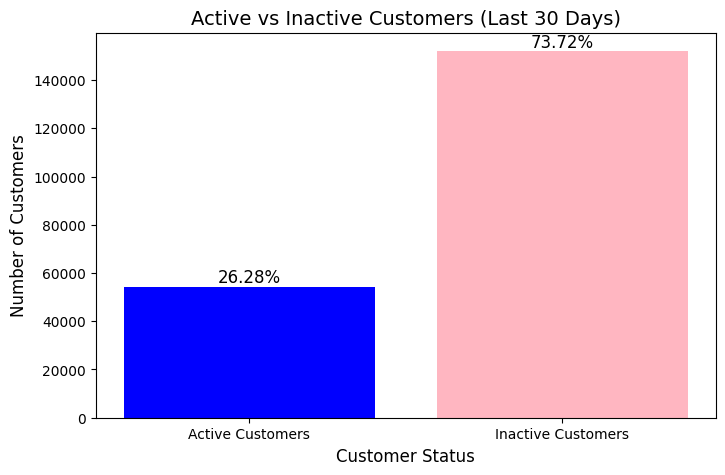

In [12]:
# Data for plotting
categories = ['Active Customers', 'Inactive Customers']
counts = [active_customers_30_days_count, inactive_customers_30_days_count]
percentages = [active_rate_30_days, churn_rate_30_days]

# Create the plot
plt.figure(figsize=(8, 5))
bars = plt.bar(categories, counts, color=['blue', 'lightpink'])

# Add titles and labels
plt.title('Active vs Inactive Customers (Last 30 Days)', fontsize=14)
plt.xlabel('Customer Status', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)

# Add percentage annotations above the bars
for i, bar in enumerate(bars):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 50, f'{percentages[i]:.2f}%', ha='center', va='bottom', fontsize=12)

# Show the plot
plt.show()

# Future churn percentages

### Feature Engineering:
We calculate days_since_last_order, which represents how many days have passed since the customer's last order.
The churned column is created by checking if the days_since_last_order is greater than the churn_threshold (30 days).

In [23]:
order_products = pd.read_csv("/Users/rishikeshdhokare/Documents/Ironhack/FinalProject/instacart-customer-churn-analysis/datafiles/order_products.csv")
order_products.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8.0
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8.0
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8.0


In [25]:
order_products.columns

Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered',
       'product_name', 'aisle_id', 'department_id', 'aisle', 'department',
       'user_id', 'eval_set', 'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order'],
      dtype='object')

In [29]:
# Check if 'user_id' and 'churn_next_30_days' exist in order_products
print("Columns in order_products:", order_products.columns)

# Creating the churn_next_30_days column: 1 if customer is inactive in next 30 days, 0 otherwise
# Assuming you have order_dates or a similar method to determine the churn
# Otherwise, you'd need to define churn logic based on inactivity over 30 days.

# Here we mock the creation of the churn_next_30_days for illustration (replace with actual logic):
order_products['churn_next_30_days'] = order_products.groupby('user_id')['days_since_prior_order'].transform(
    lambda x: (x.max() > 30).astype(int)  # Assuming customers inactive for 30+ days are considered churned
)

# Check if the churn_next_30_days column was created
print(order_products[['user_id', 'churn_next_30_days']].drop_duplicates().head())

# Enhanced Feature Engineering
user_features = order_products.groupby('user_id').agg(
    total_orders=('order_id', 'nunique'),
    avg_days_between_orders=('days_since_prior_order', 'mean'),
    reorder_rate=('reordered', 'mean'),
    total_products_ordered=('product_id', 'count'),
    unique_products_ordered=('product_id', 'nunique'),
    last_order_day=('days_since_prior_order', 'last'),
    avg_days_last_3_orders=('days_since_prior_order', lambda x: x.tail(3).mean())  # Average days for last 3 orders
).reset_index()

# Check intermediate result of user_features
print("user_features created successfully. Sample data:\n", user_features.head())

# Define churn target variable based on the last order
# Merge churn_next_30_days with user_features based on 'user_id'
user_churn = order_products[['user_id', 'churn_next_30_days']].drop_duplicates(subset='user_id', keep='last')

# Check if 'churn_next_30_days' exists in user_churn
print("user_churn sample data:\n", user_churn.head())

# Merge user_features with churn data
user_features = user_features.merge(user_churn, on='user_id', how='left')

# Ensure 'churn_next_30_days' exists before moving forward
print("user_features after merge. Sample data:\n", user_features.head())

# Split features (X) and target (y)
X = user_features.drop(columns=['churn_next_30_days', 'user_id'], errors='ignore')
y = user_features['churn_next_30_days']

# Check final shape of X and y
print(f"Features shape: {X.shape}, Target shape: {y.shape}")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

# Check feature importance
feature_importances = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)


Columns in order_products: Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered',
       'product_name', 'aisle_id', 'department_id', 'aisle', 'department',
       'user_id', 'eval_set', 'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order'],
      dtype='object')
    user_id  churn_next_30_days
0    202279                   0
9    205970                   0
17   178520                   0
30   156122                   0
56    22352                   0
user_features created successfully. Sample data:
    user_id  total_orders  avg_days_between_orders  reorder_rate  \
0        1            11                19.200000      0.728571   
1        2            15                18.009390      0.464602   
2        3            12                11.487179      0.625000   
3        4             5                15.357143      0.055556   
4        5             5                12.314286      0.391304   

   total_products_ordered  unique_products_ordered

In [31]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters found:  {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}


In [33]:
best_clf = RandomForestClassifier(
    max_depth=10,
    min_samples_split=2,
    n_estimators=50,
    random_state=42
)

best_clf.fit(X_train, y_train)


RandomForestClassifier(max_depth=10, n_estimators=50, random_state=42)

/opt/anaconda3/envs/bigquery-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


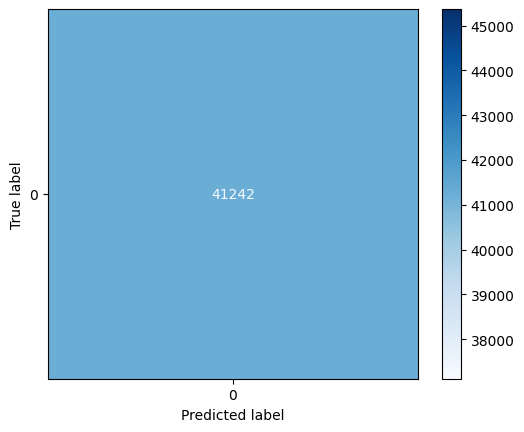

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = best_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_clf.classes_)
disp.plot(cmap='Blues')


In [37]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     41242

    accuracy                           1.00     41242
   macro avg       1.00      1.00      1.00     41242
weighted avg       1.00      1.00      1.00     41242



In [39]:
print(y_train.value_counts())
print(y_test.value_counts())

churn_next_30_days
0    164967
Name: count, dtype: int64
churn_next_30_days
0    41242
Name: count, dtype: int64


In [51]:
from sklearn.utils import resample

# Concatenate X and y into one DataFrame
df = pd.concat([X, y], axis=1)

# Separate the majority and minority classes
majority_class = df[df['churn_next_30_days'] == 0]
minority_class = df[df['churn_next_30_days'] == 1]

# Upsample the minority class (repeat samples to balance the dataset)
minority_upsampled = resample(minority_class,
                              replace=True,           # Sample with replacement
                              n_samples=len(majority_class),  # Equalize the class sizes
                              random_state=42)

# Combine the majority class with the upsampled minority class
df_balanced = pd.concat([majority_class, minority_upsampled])

# Separate the features and target again
X_balanced = df_balanced.drop('churn_next_30_days', axis=1)
y_balanced = df_balanced['churn_next_30_days']


ValueError: high <= 0

In [55]:
import numpy as np

# Corrected range (high > 0)
np.random.randint(0, 10, size=10)  # Generates random integers between 0 and 9


array([1, 9, 1, 0, 0, 9, 0, 9, 3, 9])

In [57]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')  # or 'median' based on the distribution
X_imputed = imputer.fit_transform(X)  # Fill missing values in features


In [63]:
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

# Create an imputer to fill missing values
imputer = SimpleImputer(strategy='mean')  # You can also use 'median' or 'most_frequent'
X_imputed = imputer.fit_transform(X)

# Now apply SMOTE on the imputed data
smote = SMOTE(sampling_strategy='auto')
X_resampled, y_resampled = smote.fit_resample(X_imputed, y)

# Check the class distribution after SMOTE
from collections import Counter
print("After SMOTE:", Counter(y_resampled))


ValueError: The target 'y' needs to have more than 1 class. Got 1 class instead

In [27]:
# Load the dataset
orders = pd.read_csv('/Users/rishikeshdhokare/Documents/Ironhack/FinalProject/instacart-market-basket-analysis/datafiles/orders.csv')

# Convert 'days_since_prior_order' to numeric (if needed)
orders['days_since_prior_order'] = pd.to_numeric(orders['days_since_prior_order'], errors='coerce')

# Feature Engineering: Create relevant features
# Create an 'order_date' column to simulate dates for order analysis
orders['order_date'] = pd.to_datetime(orders['order_number'], unit='D')

# Calculate 'days_since_last_order' for each user
orders['days_since_last_order'] = orders.groupby('user_id')['order_date'].transform(lambda x: (x.max() - x).dt.days)

# Define churn based on inactivity (no orders in the last 30 days)
churn_threshold = 30
orders['churned'] = orders['days_since_last_order'] > churn_threshold

# Aggregate features for each user
user_features = orders.groupby('user_id').agg(
    total_orders=('order_id', 'count'),
    average_order_value=('days_since_prior_order', 'mean'),
    max_days_since_last_order=('days_since_last_order', 'max'),
    total_days_since_last_order=('days_since_last_order', 'sum'),
    churned=('churned', 'max')  # Target variable indicating if the customer churned
).reset_index()

print(user_features)

        user_id  total_orders  average_order_value  max_days_since_last_order  \
0             1            11            19.000000                         10   
1             2            15            16.285714                         14   
2             3            13            12.000000                         12   
3             4             6            17.000000                          5   
4             5             5            11.500000                          4   
...         ...           ...                  ...                        ...   
206204   206205             4            16.666667                          3   
206205   206206            68             3.716418                         67   
206206   206207            17            14.312500                         16   
206207   206208            50             7.367347                         49   
206208   206209            14            18.461538                         13   

        total_days_since_la

In [106]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Feature engineering
orders['reordered'] = orders['reorder'].apply(lambda x: 1 if x > 0 else 0)  # Convert reorder to binary (1: reordered, 0: not reordered)
X = orders[['order_number', 'add_to_cart_order', 'days_since_prior_order', 'day_of_week', 'hour']]  # Features
y = orders['reordered']  # Target variable

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training with RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, class_weight='balanced')  # Using class_weight='balanced' for imbalance
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate model performance
print(classification_report(y_test, y_pred))

# Feature importance visualization
importances = model.feature_importances_
features = X.columns
plt.barh(features, importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Random Forest')
plt.show()


KeyError: 'reorder'

### Define feature and target

Correlation with churned:
churned                        1.000000
total_orders                   0.826026
max_days_since_last_order      0.826026
total_days_since_last_order    0.733233
user_id                       -0.001318
average_order_value           -0.477281
Name: churned, dtype: float64


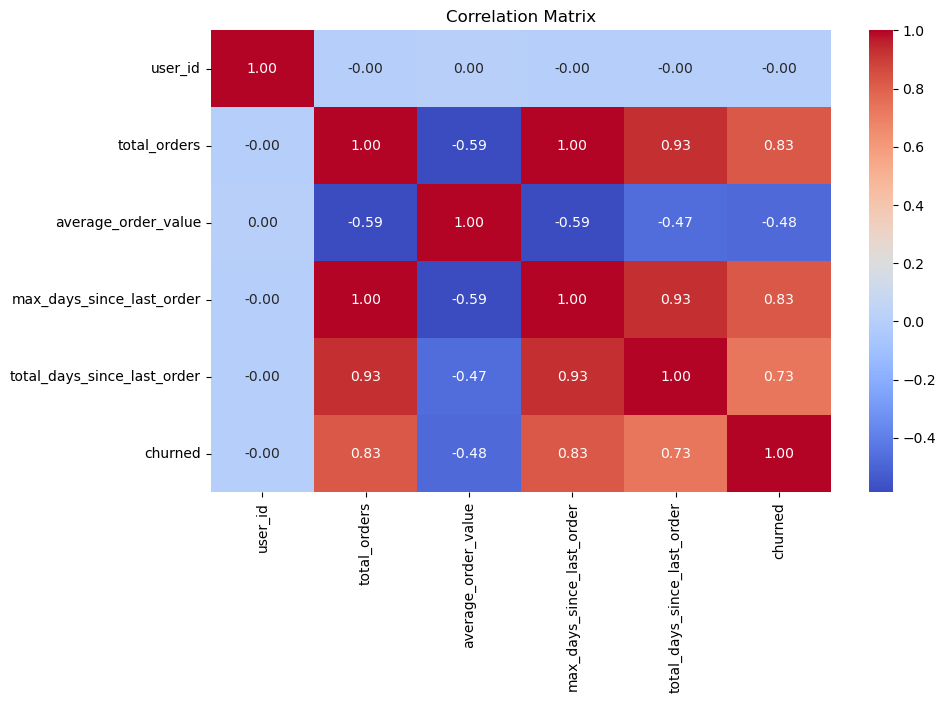

In [76]:
# Inspect correlation matrix between features and the target variable 'churned'
correlation_matrix = user_features.corr()

# Display the correlation of all features with the target variable 'churned'
print("Correlation with churned:")
print(correlation_matrix['churned'].sort_values(ascending=False))

# Optionally, visualize the correlation matrix using a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


In [78]:
# Define features and target variable
features = user_features[['total_orders', 'average_order_value', 'max_days_since_last_order', 'total_days_since_last_order']]
target = user_features['churned']

# Display the features and target
print("Features:\n", features.head())
print("Target:\n", target.head())

Features:
    total_orders  average_order_value  max_days_since_last_order  \
0            11            19.000000                         10   
1            15            16.285714                         14   
2            13            12.000000                         12   
3             6            17.000000                          5   
4             5            11.500000                          4   

   total_days_since_last_order  
0                           55  
1                          105  
2                           78  
3                           15  
4                           10  
Target:
 0    False
1    False
2    False
3    False
4    False
Name: churned, dtype: bool


### Modeling:
We use a Random Forest Classifier to predict whether a customer will churn based on features such as the total number of orders, average order value, and maximum days since the last order

### KNN model

In [80]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state = 42)
normalizer = MinMaxScaler()
normalizer.fit(X_train)

X_train_norm = normalizer.transform(X_train)
X_test_norm = normalizer.transform(X_test)

knn = KNeighborsRegressor(n_neighbors=10)
knn.fit(X_train_norm, y_train)

pred = knn.predict(X_test_norm)

knn_acuracy = knn.score(X_test_norm, y_test)
print("KNN Model Accuray:", knn_acuracy)

KNN Model Accuray: 0.9999319968170386


### Linear Regression

In [82]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

pred = lin_reg.predict(X_test)
print("MAE", mean_absolute_error(pred, y_test))
print("RMSE", mean_squared_error(pred, y_test, squared=False))
print("R2 score", lin_reg.score(X_test, y_test))

MAE 0.13706813413626476
RMSE 0.18913114903356523
R2 score 0.6959947099411847


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Decision Tree

In [58]:
tree = DecisionTreeRegressor(max_depth=10)
tree.fit(X_train_norm, y_train)
pred = tree.predict(X_test_norm)

print("MAE", mean_absolute_error(pred, y_test))
print("RMSE", mean_squared_error(pred, y_test, squared=False))
print("R2 score", tree.score(X_test_norm, y_test))

MAE 0.0
RMSE 0.0
R2 score 1.0


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Random Forest

In [88]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Fit the RandomForestClassifier model
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)

# Make predictions
y_pred_rf = model.predict(X_test)

# Classification metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Results:")
print(f'Accuracy: {accuracy_rf:.2f}')

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

# Classification Report (includes precision, recall, f1-score)
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))


Random Forest Results:
Accuracy: 1.00
Confusion Matrix:
[[35624     0]
 [    0  5618]]
Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     35624
        True       1.00      1.00      1.00      5618

    accuracy                           1.00     41242
   macro avg       1.00      1.00      1.00     41242
weighted avg       1.00      1.00      1.00     41242



In [90]:
from sklearn.model_selection import cross_val_score

cross_val_accuracy = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print(f'Cross-Validation Accuracy: {cross_val_accuracy.mean():.2f}')


Cross-Validation Accuracy: 1.00


In [92]:
print(user_features['churned'].value_counts())

churned
False    178500
True      27709
Name: count, dtype: int64


In [94]:
from sklearn.metrics import classification_report, roc_auc_score

# Print classification report (includes precision, recall, f1-score)
print(classification_report(y_test, y_pred_rf))

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_rf)
print(f"ROC-AUC Score: {roc_auc:.2f}")


              precision    recall  f1-score   support

       False       1.00      1.00      1.00     35624
        True       1.00      1.00      1.00      5618

    accuracy                           1.00     41242
   macro avg       1.00      1.00      1.00     41242
weighted avg       1.00      1.00      1.00     41242

ROC-AUC Score: 1.00


In [96]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

skf = StratifiedKFold(n_splits=5)
scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy')
print(f"Cross-validation accuracy scores: {scores}")


Cross-validation accuracy scores: [1. 1. 1. 1. 1.]


In [98]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Predict on the test data
y_pred = model.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# ROC AUC score
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print(f"ROC AUC Score: {roc_auc:.2f}")


Confusion Matrix:
[[35624     0]
 [    0  5618]]
Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     35624
        True       1.00      1.00      1.00      5618

    accuracy                           1.00     41242
   macro avg       1.00      1.00      1.00     41242
weighted avg       1.00      1.00      1.00     41242

ROC AUC Score: 1.00


In [100]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report

# Define Stratified K-Fold
skf = StratifiedKFold(n_splits=5)

# Cross-validation loop
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit model on training data
    model = RandomForestClassifier(n_estimators=100)
    model.fit(X_train, y_train)

    # Predict on test data
    y_pred = model.predict(X_test)

    # Print classification report
    print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       False       1.00      1.00      1.00     35700
        True       1.00      1.00      1.00      5542

    accuracy                           1.00     41242
   macro avg       1.00      1.00      1.00     41242
weighted avg       1.00      1.00      1.00     41242

              precision    recall  f1-score   support

       False       1.00      1.00      1.00     35700
        True       1.00      1.00      1.00      5542

    accuracy                           1.00     41242
   macro avg       1.00      1.00      1.00     41242
weighted avg       1.00      1.00      1.00     41242

              precision    recall  f1-score   support

       False       1.00      1.00      1.00     35700
        True       1.00      1.00      1.00      5542

    accuracy                           1.00     41242
   macro avg       1.00      1.00      1.00     41242
weighted avg       1.00      1.00      1.00     41242

              preci

In [104]:
model = RandomForestClassifier(n_estimators=100, class_weight='balanced')
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced', None]
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)


{'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}


### Gradient Boosting Regressor

In [63]:
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

y_pred_gb = gb_model.predict(X_test)

mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)
print("\nGradient Boosting Results:")
print(f'Mean Squared Error: {mse_gb:.2f}')
print(f'R^2 Score: {r2_gb:.2f}')


Gradient Boosting Results:
Mean Squared Error: 0.00
R^2 Score: 1.00


### Ada Boost Regressor

In [66]:
base_model = DecisionTreeRegressor(max_depth=3)  

ada_model = AdaBoostRegressor(estimator=base_model, n_estimators=50, random_state=42)
ada_model.fit(X_train, y_train)

y_pred_ada = ada_model.predict(X_test)

mse_ada = mean_squared_error(y_test, y_pred_ada)
r2_ada = r2_score(y_test, y_pred_ada)
print("\nAdaptive Boosting Results:")
print(f'Mean Squared Error: {mse_ada:.2f}')
print(f'R^2 Score: {r2_ada:.2f}')


Adaptive Boosting Results:
Mean Squared Error: 0.00
R^2 Score: 1.00


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load the dataset
orders = pd.read_csv('/Users/rishikeshdhokare/Documents/Ironhack/FinalProject/instacart-market-basket-analysis/datafiles/orders.csv')

# Convert 'days_since_prior_order' to numeric (if needed)
orders['days_since_prior_order'] = pd.to_numeric(orders['days_since_prior_order'], errors='coerce')

# Start with an arbitrary date for each user (e.g., 2021-01-01) as their first order date
orders['order_date'] = pd.to_datetime('2021-01-01')
orders = orders.sort_values(by=['user_id', 'order_number'])

# Use cumulative sum of days_since_prior_order to create order_date for each order per user
orders['order_date'] += orders.groupby('user_id')['days_since_prior_order'].cumsum().fillna(0).apply(pd.Timedelta, unit='D')

# Feature Engineering

# Calculate average order frequency per user
user_order_freq = orders.groupby('user_id')['days_since_prior_order'].mean().reset_index().rename(columns={'days_since_prior_order': 'avg_days_between_orders'})

# Calculate recency (days since last order) for each user
last_order_date = orders.groupby('user_id')['order_date'].max().reset_index().rename(columns={'order_date': 'last_order_date'})
last_order_date['days_since_last_order'] = (orders['order_date'].max() - last_order_date['last_order_date']).dt.days

# Calculate total number of orders per user
user_order_count = orders.groupby('user_id')['order_number'].count().reset_index().rename(columns={'order_number': 'total_orders'})

# Merge features into a single DataFrame
user_features = user_order_freq.merge(last_order_date, on='user_id').merge(user_order_count, on='user_id')

# Define the churn threshold
churn_threshold = 30
user_features['churned'] = user_features['days_since_last_order'] > churn_threshold
user_features['churned'] = user_features['churned'].astype(int)

# Define Features and Target
X = user_features[['avg_days_between_orders', 'days_since_last_order', 'total_orders']]
y = user_features['churned']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions on the whole dataset (including test and training data)
user_features['predicted_churn'] = model.predict(X)

# Calculate churn rate for the next 30 days (percentage of churned users)
predicted_churn_rate = user_features['predicted_churn'].mean() * 100

# Calculate total number of unique customers and number of inactive customers (churned)
total_customers = user_features.shape[0]
inactive_customers = user_features[user_features['predicted_churn'] == 1].shape[0]

# Display the results
print(f"Total number of unique customers: {total_customers}")
print(f"Number of inactive customers in the last 30 days: {inactive_customers}")
print(f"Predicted churn rate for the next 30 days: {predicted_churn_rate:.2f}%")


Total number of unique customers: 206209
Number of inactive customers in the last 30 days: 184660
Predicted churn rate for the next 30 days: 89.55%


In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE

# Load the dataset
orders = pd.read_csv('/Users/rishikeshdhokare/Documents/Ironhack/FinalProject/instacart-market-basket-analysis/datafiles/orders.csv')

# Convert 'days_since_prior_order' to numeric (if needed)
orders['days_since_prior_order'] = pd.to_numeric(orders['days_since_prior_order'], errors='coerce')

# Start with an arbitrary date for each user (e.g., 2021-01-01) as their first order date
orders['order_date'] = pd.to_datetime('2021-01-01')
orders = orders.sort_values(by=['user_id', 'order_number'])

# Use cumulative sum of days_since_prior_order to create order_date for each order per user
orders['order_date'] += orders.groupby('user_id')['days_since_prior_order'].cumsum().fillna(0).apply(pd.Timedelta, unit='D')

# Feature Engineering

# Calculate average order frequency per user
user_order_freq = orders.groupby('user_id')['days_since_prior_order'].mean().reset_index().rename(columns={'days_since_prior_order': 'avg_days_between_orders'})

# Calculate recency (days since last order) for each user
last_order_date = orders.groupby('user_id')['order_date'].max().reset_index().rename(columns={'order_date': 'last_order_date'})
last_order_date['days_since_last_order'] = (orders['order_date'].max() - last_order_date['last_order_date']).dt.days

# Calculate total number of orders per user
user_order_count = orders.groupby('user_id')['order_number'].count().reset_index().rename(columns={'order_number': 'total_orders'})

# Merge features into a single DataFrame
user_features = user_order_freq.merge(last_order_date, on='user_id').merge(user_order_count, on='user_id')

# Define the churn threshold
churn_threshold = 30
user_features['churned'] = user_features['days_since_last_order'] > churn_threshold
user_features['churned'] = user_features['churned'].astype(int)

# Define Features and Target
X = user_features[['avg_days_between_orders', 'days_since_last_order', 'total_orders']]
y = user_features['churned']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Initialize the model
model = RandomForestClassifier(random_state=42)

# Define hyperparameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', None]  # Adjusting class weights can help with imbalanced classes
}

# Use GridSearchCV to tune the hyperparameters
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=StratifiedKFold(5), scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train_res, y_train_res)

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the evaluation metrics
print("Model Evaluation Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Calculate churn rate for the next 30 days (percentage of churned users)
user_features['predicted_churn'] = best_model.predict(X)
predicted_churn_rate = user_features['predicted_churn'].mean() * 100

# Calculate total number of unique customers and number of inactive customers (churned)
total_customers = user_features.shape[0]
inactive_customers = user_features[user_features['predicted_churn'] == 1].shape[0]

# Display the results
print(f"Total number of unique customers: {total_customers}")
print(f"Number of inactive customers in the last 30 days: {inactive_customers}")
print(f"Predicted churn rate for the next 30 days: {predicted_churn_rate:.2f}%")


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   9.5s
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   9.5s
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  17.6s
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  39.9s
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   7.8s
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   7.4s
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  18.9s
[CV] END class_weight=balanced, max_depth=None, min_sample

In [ ]:
import pandas as pd
from sqlalchemy import create_engine

# MySQL connection details
username = 'root'
password = 'berlin13055'
host = '127.0.0.1'  # Localhost for MySQL
database = 'instacart'

# SQLconnection 
connection_string = f'mysql+mysqlconnector://{username}:{password}@{host}/{database}'
engine = create_engine(connection_string)

# File path for the CSV
csv_file_path = "/Users/rishikeshdhokare/Documents/Ironhack/FinalProject/instacart-market-basket-analysis/datafiles/order_products__prior.csv"

# Define the starting row and limit to 10 million rows
starting_row = 33081611 
rows_to_insert = 2000000 

# Column names as per the database schema 
column_names = ['order_id', 'product_id', 'add_to_cart_order', 'reordered']

try:
    # Read the CSV, starting from the row after the existing data, with only 1 million rows
    df = pd.read_csv(csv_file_path, skiprows=starting_row, nrows=rows_to_insert, header=None, names=column_names)
    
    df.to_sql(name='order_products_prior', con=engine, if_exists='append', index=False)
    
    print("Inserted 1 million rows.")

except Exception as e:
    print(f"Error occurred: {e}")

finally:
    engine.dispose()


In [11]:
from sqlalchemy import create_engine

# Set up your project ID
project_id = 'instacart-441209'

# Create the connection string (DATABASE_URI)
DATABASE_URI = f'bigquery://{project_id}'

# Create the engine
engine = create_engine(DATABASE_URI)

# Verify connection and query a BigQuery table
try:
    with engine.connect() as conn:
        result = conn.execute("SELECT * FROM `instacart-441209.instacart.orders` LIMIT 5")
        for row in result:
            print(row)
except Exception as e:
    print(f"Error: {e}")


Error: Not an executable object: 'SELECT * FROM `instacart-441209.instacart.orders` LIMIT 5'


/var/folders/43/30gtvzf54299gghzdyc8_l900000gn/T/ipykernel_17953/662794498.py:10: SADeprecationWarning: The dbapi() classmethod on dialect classes has been renamed to import_dbapi().  Implement an import_dbapi() classmethod directly on class <class 'pybigquery.sqlalchemy_bigquery.BigQueryDialect'> to remove this warning; the old .dbapi() classmethod may be maintained for backwards compatibility.
  engine = create_engine(DATABASE_URI)


In [7]:
pip install pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 10.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 11.4 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [13]:
import pandas as pd
print(pd.__version__)

2.2.3


In [1]:
import sys
print(sys.executable)

/opt/anaconda3/envs/bigquery-env/bin/python


In [11]:
export GOOGLE_APPLICATION_CREDENTIALS="/Users/rishikeshdhokare/Documents/Ironhack/instacart-441209-b8574d90d664.json"

SyntaxError: invalid syntax (2810220376.py, line 1)

In [15]:
from sqlalchemy import create_engine
import pandas as pd

# Set up your project ID
project_id = 'instacart-441209'

# Create the connection string
DATABASE_URI = f'bigquery://{project_id}'

# Create the engine
engine = create_engine(DATABASE_URI)

try:
    query = "SELECT * FROM `instacart-441209.instacart.orders` LIMIT 5"
    with engine.connect() as conn:
        result = pd.read_sql(query, conn)
        print(result)
except Exception as e:
    print(f"Error: {e}")


/var/folders/43/30gtvzf54299gghzdyc8_l900000gn/T/ipykernel_17953/1482740409.py:11: SADeprecationWarning: The dbapi() classmethod on dialect classes has been renamed to import_dbapi().  Implement an import_dbapi() classmethod directly on class <class 'pybigquery.sqlalchemy_bigquery.BigQueryDialect'> to remove this warning; the old .dbapi() classmethod may be maintained for backwards compatibility.
  engine = create_engine(DATABASE_URI)


   order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   3370391      116    prior             1          0                  5   
1   2955606      160    prior             1          1                  3   
2   2735511      177    prior             1          6                  3   
3    356906      186    prior             1          6                  4   
4   1192185      239    prior             1          3                  2   

  days_since_prior_order  
0                   None  
1                   None  
2                   None  
3                   None  
4                   None  
